# Rutina en Python para comparación de una estimación vía kriging ordinario versus una RNA

En este cuaderno de Jupyter se implementará un modelo de RNA, el cual buscará predecir el valor que toma una variable numérica continua y al mismo tiempo comparar dichos resultados con las del método geoestadístico kriging ordinario. Finalmente, se analizará si es que la RNA se acerca a los resultados de KO.  

Principales pasos: 

1.	A través de la simulación secuencial gaussiana se creará un escenario exhaustivo para una variable llamada “VA”. 
2.	Se extraerá una muestra aleatoria de dicha variable, equivalente al 35% de la población en representación de las muestras reales de los sondajes que son 3562. 
3.	Se utilizará el modelo variograma real del yacimiento de Fe para estimar con Kriging Ordinario en una malla igual a las dimensiones de la simulación. 
4.	Se entrenará una RNA que prediga el valor de la variable “VA” en la malla.
5.	Se compararán los resultados de la RNA vs KO. 
 


In [1]:
import geostatspy.GSLIB as GSLIB                          # Utilidades GSLIB y funciones envueltas
import geostatspy.geostats as geostats                    # GSLIB convertido a Python
import os                                                 # Para configurar el directorio de trabajo
import numpy as np                                        # Biblioteca de funciones matemáticas
import pandas as pd                                       # Biblioteca para manipulación de marcos de datos
import matplotlib.pyplot as plt                           # Biblioteca para salida gráfica
import scipy.stats                                        # Biblioteca de resumenes estadísticos y matemáticos
import random as rand
#NOTA: En base se avance con el codigo, se iran incorporando nuevas bibliotecas.

In [2]:
os.chdir(r"C:\Users\JUANC\00_MAESTRIA VIU\TFM\DESARROLLO DEL MODELO\GSLIB  RNA\GSLIB_FOLDER") # ruta de ejecutables de GSLIB

**Normalizado de parametros del variograma experimental**

In [4]:
sill_original =  372.92    
nugget_original = 75.01
hmaj1_original = 249.76
hmin1_original = 96.63
original_mean =  42.89
original_stdev =  18.53

**Normalizacion de Meseta y efecto pepita**

In [5]:
# Normaliza sill y nugget
total_variance = sill_original + nugget_original
normalized_sill = sill_original / total_variance
normalized_nugget = nugget_original / total_variance

**1. Creación del escenario simulado 2D**

In [6]:
# Modeling parameters, the model grid, the random seed, the target distribution, and color bar
nx = 100; ny = 100; cell_size=10                            # grid number of cells and cell size

xmin = 0; ymin =0;                                          # grid origin
xmax = 1000; ymax = 1000    # calculate the extent of model

seed = 172763650

vmin = 0; vmax = 100; cmap = plt.cm.jet           # color min and max and using the plasma color map

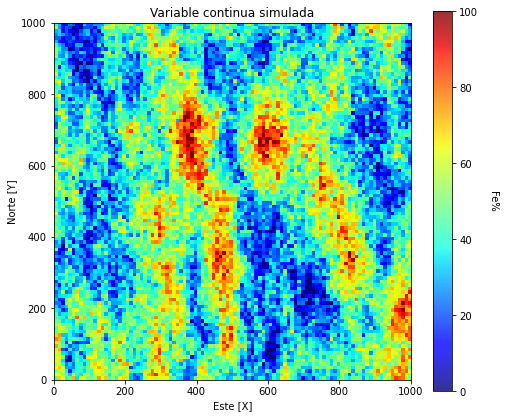

In [7]:
# Make a truth model / unconditional simulation
#va_mean = normalized_mean; va_stdev = normalized_stdev

var = GSLIB.make_variogram(nug=normalized_nugget,
                           nst=1,it1=1,
                           cc1=normalized_sill,
                           azi1=0,
                           hmaj1=hmaj1_original,
                           hmin1= hmin1_original)

VA = GSLIB.sgsim_uncond(1,nx,ny,cell_size,seed,var,"u")

VA = GSLIB.affine(VA,original_mean,original_stdev)

va_cmin = 0; va_cmax = 100

# Define el tamaño de la figura
plt.figure(figsize=(8, 7))  # Ajusta el tamaño según tus preferencias

GSLIB.pixelplt_st(VA,xmin,xmax,ymin,ymax,
                  cell_size,va_cmin,va_cmax,
                  "Variable continua simulada","Este [X]","Norte [Y]","Fe%",cmap)
plt.show()

In [8]:
df_zko = pd.DataFrame(VA)
df11 = df_zko.stack().reset_index().rename(columns={"level_0": "Norte[Y]",
                                                    "level_1": "Este[X]",
                                                    0:"VA"})

x = df11["Norte[Y]"].iloc[::-1].reset_index()

df11["Norte[Y]"] = x["Norte[Y]"]

##############################################################################################################

grid_x = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen x, coord. de termino x, nª de celdas x.
grid_y = np.linspace(0,1000, num=100, endpoint=False) #Coord. de origen y, coord. de termino y, nª de celdas y.

#En este caso la matriz es de 100 x 100 celdas.

gy = np.array(grid_y) #conversión a un array de numpy 
gx = np.array(grid_x) #conversión a un array de numpy 

yg, xg = np.meshgrid(grid_x, grid_y, indexing='ij') #Creación de la grilla (intersecciones en yg; xg)

x_g = xg.ravel() #aplanamiento de xg
y_g = yg.ravel() #aplanamiento de yg

d = {'Este[X]': x_g, 'Norte[Y]': y_g} #Columnas con coordenadas X e Y.
df = pd.DataFrame(data=d) #Creación del dataframe 

h = df["Norte[Y]"].iloc[::-1].reset_index()

df["Norte[Y]"] = h["Norte[Y]"]

df["VA"] = df11["VA"] #Traspaso de la columna VA al nuevo DataFrame.
df.head()

,Este[X],Norte[Y],VA
0,0.0,990.0,42.061071
1,10.0,990.0,31.353494
2,20.0,990.0,11.019984
3,30.0,990.0,12.062205
4,40.0,990.0,24.515475


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Este[X],10000.0,495.00,288.675135,0.000000,247.500000,495.000000,742.50000,990.000000
Norte[Y],10000.0,495.00,288.675135,0.000000,247.500000,495.000000,742.50000,990.000000
VA,10000.0,42.89,18.530927,-29.231825,29.878296,42.064978,55.50563,108.526918


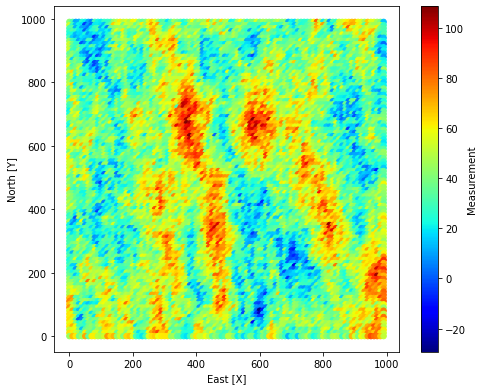

In [10]:
marker_size=30
plt.subplot(111)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA"], cmap = plt.cm.jet)
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.title('')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.subplots_adjust(left=0, bottom=0.0, right=1, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

# **Extracción muestra:**

## Extraccion de muestras condicionando a valores positivos tentro de un rango objetivo

In [11]:
import pandas as pd
import numpy as np

# Filtra las muestras con valores de VA positivos
positive_data = df[(df['VA'] >= 0) & (df['VA'] <= 100)]

# Número de muestras a seleccionar aleatoriamente
n_samples_to_select = 3562

# Asegúrate de que no seleccionas más muestras de las disponibles
n_samples_to_select = min(n_samples_to_select, len(positive_data))

# Selecciona aleatoriamente las muestras
sample_data = positive_data.sample(n=n_samples_to_select, random_state=seed)

# Ahora, 'selected_samples' contiene 3562 muestras aleatorias con valores de VA positivos


In [12]:
sample_data

,Este[X],Norte[Y],VA
7805,50.0,210.0,39.910185
9626,260.0,30.0,52.297981
9894,940.0,10.0,77.709586
3973,730.0,600.0,50.315175
9082,820.0,90.0,38.862473
...,...,...,...
2587,870.0,740.0,22.515794
2090,900.0,790.0,36.502931
2065,650.0,790.0,38.143709
8266,660.0,170.0,38.452346


## Extraccion de muestras aleatorias sin condicionante

In [71]:
# Make a datset by sampling from the truth model, and display the histogram and location map
mx = 20; my =20

sample_data1 = GSLIB.regular_sample(VA,xmin,xmax,ymin,ymax,cell_size,mx,my,nx,ny,"VA")

nsamp_random = 3562

sample_data2 = GSLIB.random_sample(VA,xmin,xmax,ymin,ymax,cell_size,nsamp_random,'VA')

sample_data = pd.concat([sample_data1,sample_data2],ignore_index = True)

In [72]:
print((sample_data["VA"].count() * 100/df11["VA"].count()), "% es el tamaño de la muestra")

35.78 % es el tamaño de la muestra


In [74]:
sample_data

,X,Y,VA
0,200.0,800.0,12.222997
1,200.0,600.0,44.709931
2,200.0,400.0,40.865010
3,200.0,200.0,45.793421
4,400.0,800.0,45.556669
...,...,...,...
3573,230.0,619.0,47.222106
3574,290.0,139.0,32.863183
3575,900.0,499.0,31.815655
3576,250.0,519.0,58.320608


**Plot de las muestras extraidas**

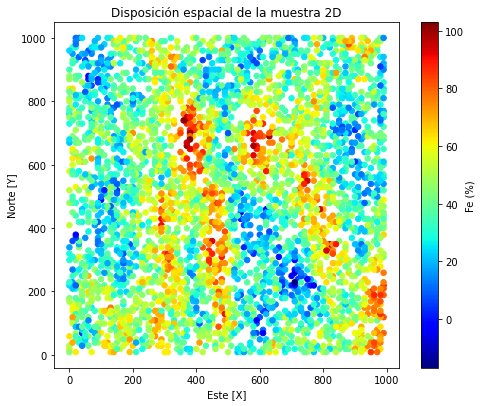

In [75]:
marker_size=30
plt.subplot(111)
plt.scatter(sample_data["X"], sample_data["Y"], marker_size, sample_data["VA"], cmap = plt.cm.jet)
plt.xlabel('Este [X]')
plt.ylabel('Norte [Y]')
plt.title('Disposición espacial de la muestra 2D')
plt.grid(False)
cbar=plt.colorbar()
#plt.clim(-4,4)

cbar.set_label('Fe (%)', labelpad=+1)
#plt.savefig("C:/Users/nubem/Desktop/EJERCICIOS_RESUELTOS_GEOESTADÍSTICA/dataset_2d_regular_aniso.png", dpi=300)
plt.subplots_adjust(left=0, bottom=0.0, right=1, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [76]:
sample_data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,3578.0,496.830632,287.470074,0.000000,250.000000,490.00000,750.00000,990.000000
Y,3578.0,501.108999,288.517463,9.000000,249.000000,499.00000,749.00000,999.000000
VA,3578.0,43.022406,18.234430,-16.885586,29.994677,41.96209,55.53665,102.992436


**3. Estimación Kriging Ordinario:**

In [77]:
vario_kri = GSLIB.make_variogram(nug=normalized_nugget,
                           nst=1,it1=1,
                           cc1=normalized_sill,
                           azi1=0,
                           hmaj1=249.76,
                           hmin1= 96.63)

In [79]:
nx = 100; ny=100; xsiz=10; ysiz=10; xmn=0; ymn= 0; ndmax=20; ndmin=1;radius=500; 

ktype=1; skmean=0; nxdis=1; nydis=1; tmin=-9999; tmax=9999

kmap, vmap = geostats.kb2d(sample_data, "X", "Y", "VA",
                           tmin, tmax,
                           nx, xmn, xsiz, ny, ymn, ysiz,
                           nxdis, nydis, ndmin, ndmax, radius, ktype, skmean, vario_kri)

  Estimated   10000 blocks 
      average   42.97265968854586  variance  244.32777406669425


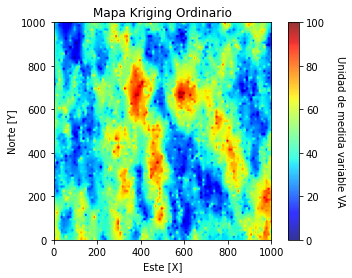

In [18]:
GSLIB.pixelplt_st(kmap,xmin,xmax,ymin,ymax,1,0,100,"Mapa Kriging Ordinario", "Este [X]", "Norte [Y]", "Unidad de medida variable VA", cmap)

In [80]:
df_kmap = pd.DataFrame(kmap) #se pasan los valores estimados al dataframe de la simulación 
df_kmap = df_kmap.stack().reset_index().rename(columns={"level_0": "Norte[Y]", "level_1": "Este[X]", 0:"VA"})

df["VA_KO"]= df_kmap["VA"]
df.head()

,Este[X],Norte[Y],VA,VA_KO,VA_RNA
0,0.0,990.0,42.061071,22.739274,22.020000
1,10.0,990.0,31.353494,20.834520,21.850000
2,20.0,990.0,11.019984,15.218079,21.709999
3,30.0,990.0,12.062205,15.781919,21.629999
4,40.0,990.0,24.515475,19.178730,21.790001


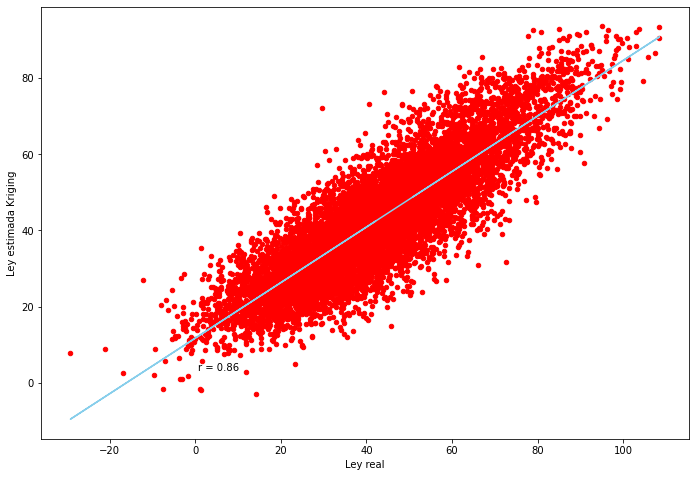

In [81]:
x = df["VA"] 
y = df["VA_KO"] 
#Calculando los coeficientes del ajuste de regresión:
a, b = np.polyfit(x, y, 1) # 1 es el grado del polinomio
r = np.corrcoef(x, y) # r = coeficiente de correlación
#print("R:", r, "a:", a, "b:", b) # b: pendiente de la recta, a: ordenada en la vertical (Y = bX + a)
plt.subplot(111)
plt.scatter(x,y, color="r", s=20)
plt.xlabel("Ley real")
plt.ylabel("Ley estimada Kriging")
plt.plot(x, a * x + b, color="skyblue")
plt.text(0.5,3.2, 'r = {0:2.2f}'.format(r[0,1]))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5)
plt.show()

**4. Implementación RNA:**

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
#from keras.optimizers import RMSprop 
from tensorflow.keras.optimizers import RMSprop
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [83]:
X = sample_data.drop('VA',axis=1) 
X

,X,Y
0,200.0,800.0
1,200.0,600.0
2,200.0,400.0
3,200.0,200.0
4,400.0,800.0
...,...,...
3573,230.0,619.0
3574,290.0,139.0
3575,900.0,499.0
3576,250.0,519.0


In [84]:
y = sample_data["VA"]
y

0       12.222997
1       44.709931
2       40.865010
3       45.793421
4       45.556669
          ...    
3573    47.222106
3574    32.863183
3575    31.815655
3576    58.320608
3577    32.221850
Name: VA, Length: 3578, dtype: float64

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=17276)

In [86]:
X_train.shape

(2862, 2)

In [87]:
X_test.shape

(716, 2)

In [88]:
X_train = pd.DataFrame(StandardScaler().fit_transform(X_train))
X_test = pd.DataFrame(StandardScaler().fit_transform(X_test))
X_train.rename(columns={0:"x", 1:"y"}, inplace=True)
X_test.rename(columns={0:"x", 1:"y"}, inplace=True)

In [89]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Definición de la arquitectura de la red neuronal

network = models.Sequential()

network.add(layers.Dense(128, activation='relu', input_shape=X_train.shape[1:]))
network.add(layers.BatchNormalization())
network.add(layers.Dense(64, activation='relu'))
#network.add(layers.BatchNormalization())
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(1)) #la última capa no tiene función de activación cuando se trata de regresión

network.summary()

# Definir el callback para reducir el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 13,377
Trainable params: 13,121
Non-trainable params: 256
_________________________________________________________________


In [90]:
# Compilacion del modelo
optimizer = RMSprop(learning_rate=0.01)
network.compile(
   loss='mean_squared_error',
   optimizer=optimizer
)


In [91]:
history = network.fit(X_train, 
                      y_train, 
                      epochs=500, 
                      batch_size = 128,
                      validation_data=(X_test, y_test),
                     callbacks=callbacks)

Epoch 1/500
23/23 [==============================] - 1s 12ms/step - loss: 527.6987 - val_loss: 1747.0452
Epoch 2/500
23/23 [==============================] - 0s 8ms/step - loss: 302.9511 - val_loss: 1703.9651
Epoch 3/500
23/23 [==============================] - 0s 7ms/step - loss: 306.9303 - val_loss: 1348.6057
Epoch 4/500
23/23 [==============================] - 0s 6ms/step - loss: 281.0517 - val_loss: 1450.4806
Epoch 5/500
23/23 [==============================] - 0s 6ms/step - loss: 279.6737 - val_loss: 1206.6545
Epoch 6/500
23/23 [==============================] - 0s 7ms/step - loss: 269.3130 - val_loss: 1200.6316
Epoch 7/500
23/23 [==============================] - 0s 5ms/step - loss: 258.4121 - val_loss: 1292.0746
Epoch 8/500
23/23 [==============================] - 0s 6ms/step - loss: 258.8921 - val_loss: 824.2078
Epoch 9/500
23/23 [==============================] - 0s 5ms/step - loss: 242.3257 - val_loss: 964.0420
Epoch 10/500
23/23 [==============================] - 0s 5ms/step

Epoch 80/500
23/23 [==============================] - 0s 6ms/step - loss: 148.7828 - val_loss: 175.2713
Epoch 81/500
23/23 [==============================] - 0s 5ms/step - loss: 150.6677 - val_loss: 173.3178
Epoch 82/500
23/23 [==============================] - 0s 5ms/step - loss: 147.7202 - val_loss: 170.4706
Epoch 83/500
23/23 [==============================] - 0s 5ms/step - loss: 151.1396 - val_loss: 176.0619
Epoch 84/500
23/23 [==============================] - 0s 6ms/step - loss: 153.4561 - val_loss: 177.1046
Epoch 85/500
23/23 [==============================] - 0s 6ms/step - loss: 148.0406 - val_loss: 177.9294
Epoch 86/500
23/23 [==============================] - 0s 5ms/step - loss: 149.0481 - val_loss: 168.7487
Epoch 87/500
23/23 [==============================] - 0s 5ms/step - loss: 149.2075 - val_loss: 180.1206
Epoch 88/500
23/23 [==============================] - 0s 5ms/step - loss: 146.4688 - val_loss: 170.9170
Epoch 89/500
23/23 [==============================] - 0s 5ms/ste

<AxesSubplot:>

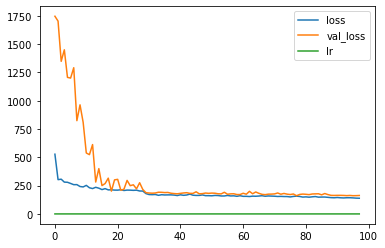

In [92]:
model_loss = pd.DataFrame(network.history.history)
model_loss.plot()

In [93]:
test_loss = network.evaluate(X_test, y_test)
print('test_mse:', test_loss)

23/23 [==============================] - 0s 2ms/step - loss: 160.8938
test_mse: 160.89382934570312


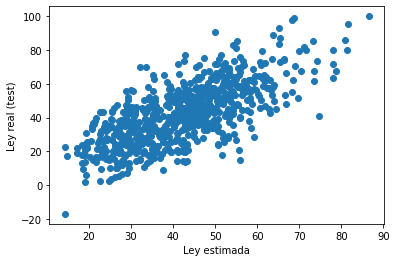

In [94]:
y_pred = network.predict(X_test).round(2)

plt.scatter(y_pred,y_test) #comparación valores reales del conjunto de prueba vs predicciones del modelo
plt.xlabel("Ley estimada")
plt.ylabel("Ley real (test)")
plt.show()

In [95]:
df.head()

,Este[X],Norte[Y],VA,VA_KO,VA_RNA
0,0.0,990.0,42.061071,22.739274,22.020000
1,10.0,990.0,31.353494,20.834520,21.850000
2,20.0,990.0,11.019984,15.218079,21.709999
3,30.0,990.0,12.062205,15.781919,21.629999
4,40.0,990.0,24.515475,19.178730,21.790001


In [96]:
df_malla = pd.DataFrame()

df_malla["X"] = df["Este[X]"]
df_malla["Y"] = df["Norte[Y]"]

df_malla = pd.DataFrame(StandardScaler().fit_transform(df_malla))
df_malla.rename(columns={0:"X", 1:"Y"}, inplace=True)

df_malla.head()

,X,Y
0,-1.714816,1.714816
1,-1.680173,1.714816
2,-1.645531,1.714816
3,-1.610888,1.714816
4,-1.576245,1.714816


In [97]:
y_pred = network.predict(df_malla).round(2) #uso del modelo para un conjunto nuevo de datos de entrada (bloques zona óxido)
df["VA_RNA"] = y_pred
df.head()

,Este[X],Norte[Y],VA,VA_KO,VA_RNA
0,0.0,990.0,42.061071,22.739274,20.790001
1,10.0,990.0,31.353494,20.834520,19.860001
2,20.0,990.0,11.019984,15.218079,19.920000
3,30.0,990.0,12.062205,15.781919,20.040001
4,40.0,990.0,24.515475,19.178730,20.160000


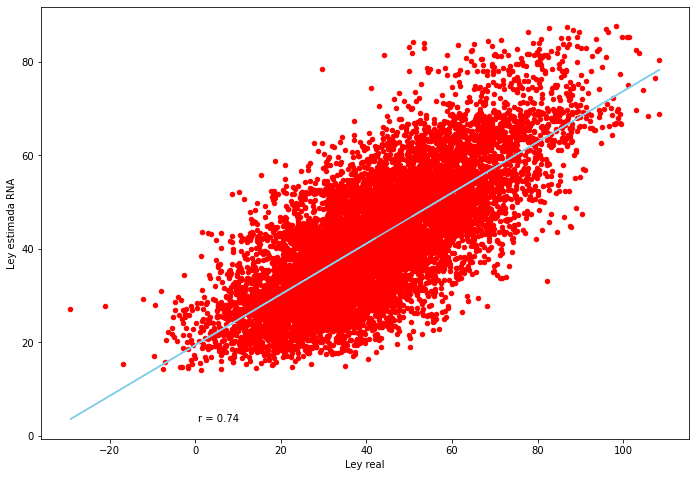

In [98]:
x = df["VA"] 
y = df["VA_RNA"] 
#Calculando los coeficientes del ajuste de regresión:
a, b = np.polyfit(x, y, 1) # 1 es el grado del polinomio
r = np.corrcoef(x, y) # r = coeficiente de correlación
#print("R:", r, "a:", a, "b:", b) # b: pendiente de la recta, a: ordenada en la vertical (Y = bX + a)
plt.subplot(111)
plt.scatter(x,y, color="r", s=20)
plt.xlabel("Ley real")
plt.ylabel("Ley estimada RNA")
plt.plot(x, a * x + b, color="skyblue")
plt.text(0.5,3.2, 'r = {0:2.2f}'.format(r[0,1]))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5)
plt.show()

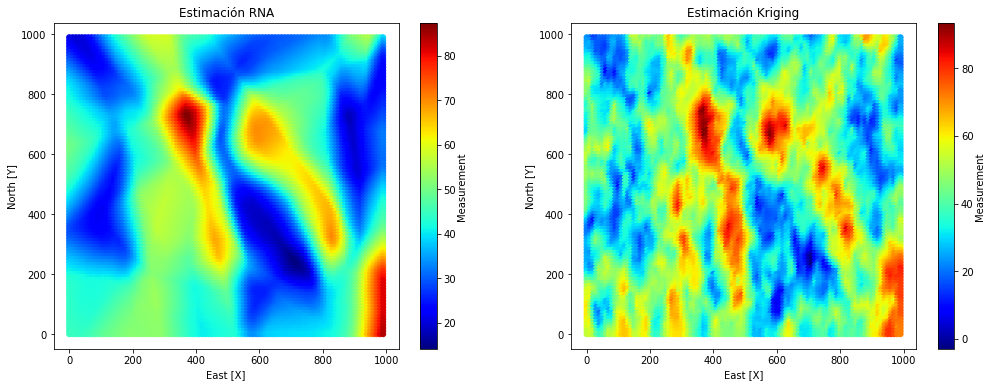

In [99]:
fig = plt.figure(figsize=(17,6))
plt.subplot(121)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA_RNA"], cmap = plt.cm.jet)
plt.title("Estimación RNA")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.subplot(122)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA_KO"], cmap = plt.cm.jet)
plt.title("Estimación Kriging")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.show()

In [100]:
sample_data

,X,Y,VA
0,200.0,800.0,12.222997
1,200.0,600.0,44.709931
2,200.0,400.0,40.865010
3,200.0,200.0,45.793421
4,400.0,800.0,45.556669
...,...,...,...
3573,230.0,619.0,47.222106
3574,290.0,139.0,32.863183
3575,900.0,499.0,31.815655
3576,250.0,519.0,58.320608


In [101]:
df_predictoras=sample_data.iloc[:,:-1]
df_predictoras.shape

(3578, 2)

In [102]:
df_objetivo=sample_data.iloc[:,-1:]
df_objetivo.shape

(3578, 1)

# VALIDACION CRUZADA

In [103]:

from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()

num_neuronas = df_predictoras.shape[1] #número de entradas
num_neuronas_salida = df_objetivo.shape[1]# Indicar tantas neuronas de salida como clases a predecir, en este caso 3

network = models.Sequential()
network.add(layers.Dense(64, activation='relu', input_shape=df_predictoras.shape[1:]))
network.add(layers.BatchNormalization())
network.add(layers.Dense(64, activation='relu',
                         kernel_initializer='he_normal'
                        )
           )
network.add(layers.BatchNormalization())
network.add(layers.Dense(32, activation='relu',
                         kernel_initializer='he_normal'
                       )
          )
#network.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
#network.add(layers.BatchNormalization())
network.add(layers.Dense(num_neuronas_salida)) #la última capa no tiene función de activación cuando se trata de regresión

# Definir el callback para reducir el learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
callbacks = [reduce_lr, early_stop]

# Resumen de las capas del modelo
network.summary()

# Compilacion del modelo
optimizer = Adam(learning_rate=0.01)
network.compile(
   loss = 'mean_squared_error', 
   optimizer = optimizer,
   #metrics=['mean_squared_error']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,977
Trainable params: 6,721
Non-trainable params: 256
____________________________________________________

In [104]:
from sklearn.model_selection import KFold

# Define el número de divisiones (folds) para la validación cruzada
n_splits = 10  # Puedes ajustar este valor según tus necesidades

# Crea un objeto KFold para dividir los datos
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Listas para almacenar los resultados de cada fold
r2_scores = []
mae_scores = []
mse_scores = []
X = df_predictoras
y = df_objetivo
# Itera a través de las divisiones de la validación cruzada
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Escala los datos de entrenamiento y prueba
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Crea y entrena tu modelo en cada fold (aquí asumo que ya has definido tu modelo)
    

    # Entrena el modelo con X_train_scaled y y_train
    #Entrenamiento del modelo
    history = network.fit(X_train_scaled, 
                          y_train, 
                          epochs=100, 
                          batch_size = 180,
                          validation_data=(X_test_scaled, y_test),
                          verbose=1,
                          callbacks=callbacks
                         )

    # Realiza predicciones en el conjunto de prueba
    y_pred = network.predict(X_test_scaled)

    # Calcula las métricas para este fold
    r2 = metrics.r2_score(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Almacena los resultados en las listas
    r2_scores.append(r2)
    mae_scores.append(mae)
    mse_scores.append(mse)

# Calcula el promedio de las métricas en todos los folds
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)
avg_mse = np.mean(mse_scores)

# Imprime los resultados finales
print("Promedio de R^2:", avg_r2)
print("Promedio de MAE:", avg_mae)
print("Promedio de MSE:", avg_mse)

Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 1372.1642 - val_loss: 1328.9967
Epoch 2/100
18/18 [==============================] - 0s 9ms/step - loss: 324.9844 - val_loss: 1050.6708
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 246.9252 - val_loss: 912.0731
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 227.7169 - val_loss: 850.4148
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 215.1756 - val_loss: 814.3286
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 212.5013 - val_loss: 826.2977
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 201.8349 - val_loss: 802.2792
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 195.1271 - val_loss: 755.8781
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 194.4512 - val_loss: 674.9891
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - l

Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 133.0385 - val_loss: 127.3512
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 134.0038 - val_loss: 127.1793
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 134.0260 - val_loss: 130.2628
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 134.1299 - val_loss: 127.3230
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 132.9868 - val_loss: 130.6306
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 133.9267 - val_loss: 131.0230
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 133.4722 - val_loss: 127.2277
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 133.7391 - val_loss: 128.2587
Epoch 88/100
18/18 [==============================] - 0s 6ms/step - loss: 130.4793 - val_loss: 127.6954
Epoch 89/100
18/18 [==============================] - 0s 6ms/ste

18/18 [==============================] - 0s 5ms/step - loss: 128.6071 - val_loss: 130.1370
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 127.4950 - val_loss: 130.0384
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 128.2701 - val_loss: 129.8417
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 126.4117 - val_loss: 130.2688
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 125.2535 - val_loss: 129.8559
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 127.3020 - val_loss: 129.6761
Epoch 20/100
18/18 [==============================] - 0s 5ms/step - loss: 127.1525 - val_loss: 130.1475
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 124.8081 - val_loss: 129.7941
Epoch 1/100
18/18 [==============================] - 0s 6ms/step - loss: 127.7868 - val_loss: 110.2672
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 129.4

In [105]:
r2_scores

[0.5864360719187389,
 0.5882933693998684,
 0.6702051038208552,
 0.6107342582997779,
 0.6784877988223366,
 0.6442688766465932,
 0.6720440511767154,
 0.6305620625089806,
 0.6407991358223151,
 0.6267233147927292]

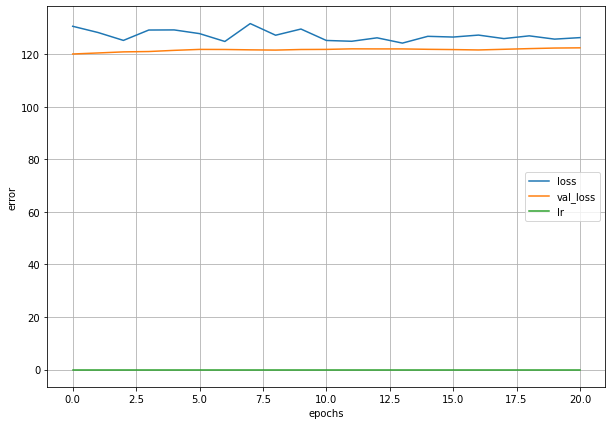

Correlación (R): 0.7922001356034286
Coeficiente de Determinación (R^2): 0.6267233147927292
Error Absoluto Medio (MAE): 8.840193975681434
Error Cuadrático Medio (MSE): 120.18302921665918


In [106]:
# Grafica de las metricas
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("error")
plt.show()

#Evaluacion del modelo
# Predecir sobre los datos de prueba
y_pred = network.predict(X_test_scaled)

# Calcular la correlación (R)
correlation = np.corrcoef(y_pred.flatten(), y_test.values.flatten())[0, 1]
print("Correlación (R):", correlation)

# Calcular el coeficiente de determinación (R^2)
r2 = metrics.r2_score(y_test, y_pred)
print("Coeficiente de Determinación (R^2):", r2)

# Calcular el error absoluto medio (MAE)
mae = metrics.mean_absolute_error(y_test, y_pred)
print("Error Absoluto Medio (MAE):", mae)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Error Cuadrático Medio (MSE):", mse)



In [107]:
# Supongamos que tienes tus predicciones en 'y_pred' y los valores reales en 'y_test'

variables = ['Fe']  # Nombres de las variables objetivo

for i, variable in enumerate(variables):
    y_test_variable = y_test.iloc[:, i]
    y_pred_variable = y_pred[:, i]

    # Calcula la correlación (R)
    correlation = np.corrcoef(y_pred_variable, y_test_variable)[0, 1]

    # Calcula el coeficiente de determinación (R^2)
    r2 = r2_score(y_test_variable, y_pred_variable)

    # Calcula el error absoluto medio (MAE)
    mae = mean_absolute_error(y_test_variable, y_pred_variable)

    # Calcula el error cuadrático medio (MSE)
    mse = mean_squared_error(y_test_variable, y_pred_variable)

    # Muestra las métricas para la variable actual
    print(f"Variable: {variable}")
    print(f"Correlación (R): {correlation}")
    print(f"Coeficiente de Determinación (R^2): {r2}")
    print(f"Error Absoluto Medio (MAE): {mae}")
    print(f"Error Cuadrático Medio (MSE): {mse}")
    print("-" * 40)  # Separador

Variable: Fe
Correlación (R): 0.7922001356034286
Coeficiente de Determinación (R^2): 0.6267233147927292
Error Absoluto Medio (MAE): 8.840193975681434
Error Cuadrático Medio (MSE): 120.18302921665918
----------------------------------------


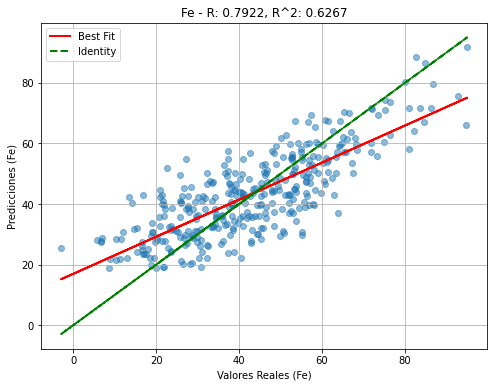

In [108]:
# Supongamos que tienes tus predicciones en 'y_pred' y los valores reales en 'y_test'

variables = ['Fe']  # Nombres de las variables objetivo

for i, variable in enumerate(variables):
    y_test_variable = y_test.iloc[:, i]
    y_pred_variable = y_pred[:, i]

    # Calcula la correlación (R)
    correlation = np.corrcoef(y_pred_variable, y_test_variable)[0, 1]

    # Calcula el coeficiente de determinación (R^2)
    r2 = r2_score(y_test_variable, y_pred_variable)

    # Calcula el error absoluto medio (MAE)
    mae = mean_absolute_error(y_test_variable, y_pred_variable)

    # Calcula el error cuadrático medio (MSE)
    mse = mean_squared_error(y_test_variable, y_pred_variable)

    # Crea el gráfico de dispersión con las métricas
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_variable, y_pred_variable, alpha=0.5)
    plt.xlabel(f"Valores Reales ({variable})")
    plt.ylabel(f"Predicciones ({variable})")
    plt.title(f"{variable} - R: {correlation:.4f}, R^2: {r2:.4f}")
    slope, intercept = np.polyfit(y_test_variable, y_pred_variable, 1)
    plt.plot(y_test_variable, slope * y_test_variable + intercept, color='red', linewidth=2, label='Best Fit')
    plt.plot(y_test_variable, y_test_variable, color='green', linestyle='--', linewidth=2, label='Identity')
    plt.legend()
    plt.grid(True)
    plt.show()

In [109]:


# Supongamos que tienes tus predicciones en 'y_pred' y los valores reales en 'y_test'

variables = ['Fe']  # Nombres de las variables objetivo
metrics_data = []

for i, variable in enumerate(variables):
    y_test_variable = y_test.iloc[:, i]
    y_pred_variable = y_pred[:, i]

    # Calcula la correlación (R)
    correlation = np.corrcoef(y_pred_variable, y_test_variable)[0, 1]

    # Calcula el coeficiente de determinación (R^2)
    r2 = r2_score(y_test_variable, y_pred_variable)

    # Calcula el error absoluto medio (MAE)
    mae = mean_absolute_error(y_test_variable, y_pred_variable)

    # Calcula el error cuadrático medio (MSE)
    mse = mean_squared_error(y_test_variable, y_pred_variable)

    # Calcula el Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Agrega las métricas a la lista
    metrics_data.append([variable, correlation, r2, mae, mse, rmse])

# Crea un DataFrame con los resultados
metrics_df = pd.DataFrame(metrics_data, columns=['Variable', 'Correlación (R)', 'Coeficiente de Determinación (R^2)', 'Error Absoluto Medio (MAE)', 'Error Cuadrático Medio (MSE)', 'Root Mean Squared Error (RMSE)'])

# Establece la columna 'Variable' como índice
metrics_df.set_index('Variable', inplace=True)

# Muestra el cuadro de métricas sin el índice numérico
metrics_df

,Correlación (R),Coeficiente de Determinación (R^2),Error Absoluto Medio (MAE),Error Cuadrático Medio (MSE),Root Mean Squared Error (RMSE)
Variable,,,,,
Fe,0.7922,0.626723,8.840194,120.183029,10.962802


In [110]:
df_malla = pd.DataFrame()

df_malla["X"] = df["Este[X]"]
df_malla["Y"] = df["Norte[Y]"]

df_malla = pd.DataFrame(StandardScaler().fit_transform(df_malla))
df_malla.rename(columns={0:"X", 1:"Y"}, inplace=True)

df_malla.head()

,X,Y
0,-1.714816,1.714816
1,-1.680173,1.714816
2,-1.645531,1.714816
3,-1.610888,1.714816
4,-1.576245,1.714816


In [111]:
y_pred = network.predict(df_malla).round(2) #uso del modelo para un conjunto nuevo de datos de entrada (bloques zona óxido)
df["VA_RNA"] = y_pred
df

,Este[X],Norte[Y],VA,VA_KO,VA_RNA
0,0.0,990.0,42.061071,22.739274,19.730000
1,10.0,990.0,31.353494,20.834520,18.410000
2,20.0,990.0,11.019984,15.218079,18.389999
3,30.0,990.0,12.062205,15.781919,18.580000
4,40.0,990.0,24.515475,19.178730,19.670000
...,...,...,...,...,...
9995,950.0,0.0,85.268140,79.466485,67.599998
9996,960.0,0.0,81.061033,79.734478,70.809998
9997,970.0,0.0,78.869765,77.258821,73.889999
9998,980.0,0.0,67.071867,72.675368,76.980003


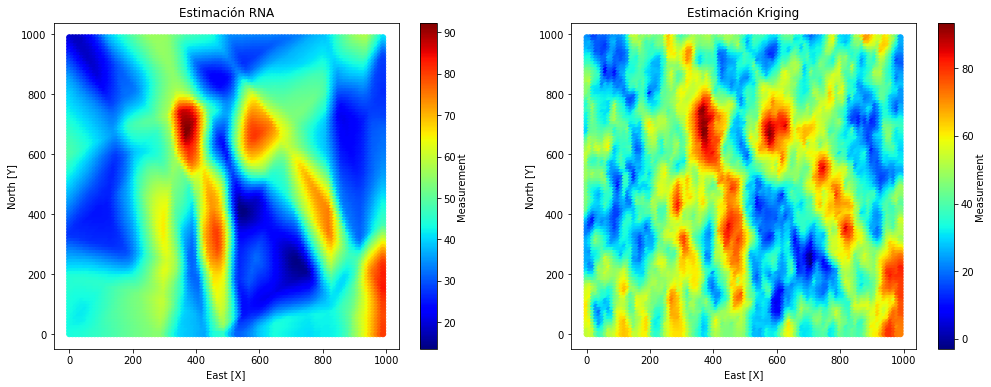

In [112]:
fig = plt.figure(figsize=(17,6))
plt.subplot(121)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA_RNA"], cmap = plt.cm.jet)
plt.title("Estimación RNA")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.subplot(122)
plt.scatter(df["Este[X]"], df["Norte[Y]"], marker_size, df["VA_KO"], cmap = plt.cm.jet)
plt.title("Estimación Kriging")
plt.xlabel('East [X]')
plt.ylabel('North [Y]')
plt.grid(False)
cbar=plt.colorbar()
cbar.set_label('Measurement', labelpad=+1)
plt.show()

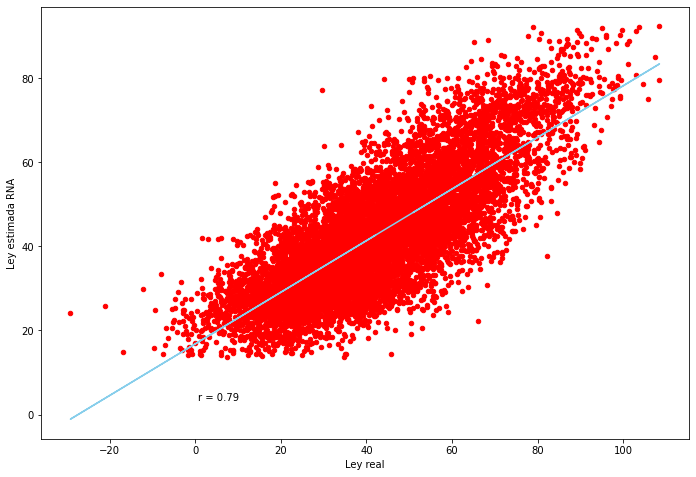

In [113]:
x = df["VA"] 
y = df["VA_RNA"] 
#Calculando los coeficientes del ajuste de regresión:
a, b = np.polyfit(x, y, 1) # 1 es el grado del polinomio
r = np.corrcoef(x, y) # r = coeficiente de correlación
#print("R:", r, "a:", a, "b:", b) # b: pendiente de la recta, a: ordenada en la vertical (Y = bX + a)
plt.subplot(111)
plt.scatter(x,y, color="r", s=20)
plt.xlabel("Ley real")
plt.ylabel("Ley estimada RNA")
plt.plot(x, a * x + b, color="skyblue")
plt.text(0.5,3.2, 'r = {0:2.2f}'.format(r[0,1]))
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5)
plt.show()

# GUARDADO DE MODELO Y SAMPLE DATA

In [60]:
# Importa las bibliotecas necesarias
import h5py

# Guarda el modelo en un archivo ".h5"
network.save('modelo_Fe_RNA_vs_KO_66.h5')

print("Modelo guardado correctamente en 'modelo_Fe_RNA_vs_KO_066.h5'")

# Para cargar el modelo posteriormente:
#modelo_cargado = load_model('modelo_Fe_RNA_Kfold.h5')

Modelo guardado correctamente en 'modelo_Fe_RNA_vs_KO_066.h5'


In [61]:
sample_data

,Este[X],Norte[Y],VA
7805,50.0,210.0,39.910185
9626,260.0,30.0,52.297981
9894,940.0,10.0,77.709586
3973,730.0,600.0,50.315175
9082,820.0,90.0,38.862473
...,...,...,...
2587,870.0,740.0,22.515794
2090,900.0,790.0,36.502931
2065,650.0,790.0,38.143709
8266,660.0,170.0,38.452346


In [62]:
sample_data.to_csv('sample_data_ko66.csv', index=False)

In [63]:
df

,Este[X],Norte[Y],VA,VA_KO,VA_RNA
0,0.0,990.0,42.061071,30.933125,22.020000
1,10.0,990.0,31.353494,31.353494,21.850000
2,20.0,990.0,11.019984,19.203322,21.709999
3,30.0,990.0,12.062205,15.174319,21.629999
4,40.0,990.0,24.515475,11.842729,21.790001
...,...,...,...,...,...
9995,950.0,0.0,85.268140,70.207870,67.139999
9996,960.0,0.0,81.061033,74.656543,69.400002
9997,970.0,0.0,78.869765,75.360277,71.650002
9998,980.0,0.0,67.071867,67.071867,73.910004


In [64]:
df.to_csv('Validacion_Real_KO_RNA_066.csv', index=False)

# Metricas de Validación de Kriging y RNA

**CARGANDO RESULTADOS DE LAS PREDICCIONES**

In [3]:
import pandas as pd
df_val=pd.read_csv("Validacion_Real_KO_RNA_066.csv", sep=',')
df_val 

,Este[X],Norte[Y],VA,VA_KO,VA_RNA
0,0.0,990.0,42.061071,30.933125,22.02
1,10.0,990.0,31.353494,31.353494,21.85
2,20.0,990.0,11.019984,19.203322,21.71
3,30.0,990.0,12.062205,15.174319,21.63
4,40.0,990.0,24.515475,11.842729,21.79
...,...,...,...,...,...
9995,950.0,0.0,85.268140,70.207870,67.14
9996,960.0,0.0,81.061033,74.656543,69.40
9997,970.0,0.0,78.869765,75.360277,71.65
9998,980.0,0.0,67.071867,67.071867,73.91


In [4]:
y_real = df_val["VA"]
y_pred_kriging = df_val["VA_KO"]

## Error Cuadrático Medio (MSE)

In [6]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_real, y_pred_kriging)
mse

65.74228553979334

## Raiz del Error Cuadrático Medio (RMSE)

In [369]:
import numpy as np
rmse = np.sqrt(mse)
rmse

10.808697204186661

## Error Absoluto Medio (MAE):

In [370]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_real, y_pred_kriging)
mae

5.201319006878416

   ## Coeficiente de Determinacion ((R^2):

In [371]:
from sklearn.metrics import r2_score
r2 = r2_score(y_real, y_pred_kriging)
print("R^2 para Kriging:", r2)

R^2 para Kriging: 0.8085329880606867


## Error Porcentual Absoluto Medio (MAPE)


In [372]:
absolute_percentage_errors = np.abs((y_real - y_pred_kriging) / y_real) * 100
mape = np.mean(absolute_percentage_errors)
mape

24.318540474866413

In [7]:
from sklearn.metrics import r2_score, mean_squared_error

# Datos reales y predicciones de Kriging y Redes Neuronales
y_real = df_val['VA']
y_pred_ko = df_val['VA_KO']
y_pred_rna = df_val['VA_RNA']

# Calcular el coeficiente de determinación R^2
r2_ko = r2_score(y_real, y_pred_ko)
r2_rna = r2_score(y_real, y_pred_rna)

# Calcular el error cuadrático medio (MSE)
mse_ko = mean_squared_error(y_real, y_pred_ko)
mse_rna = mean_squared_error(y_real, y_pred_rna)

# Calcular el Root Mean Squared Error (RMSE)
rmse_ko = mean_squared_error(y_real, y_pred_ko, squared=False)
rmse_rna = mean_squared_error(y_real, y_pred_rna, squared=False)

# Calcular el coeficiente de correlación (R)
corr_ko = np.corrcoef(y_real, y_pred_ko)[0, 1]
corr_rna = np.corrcoef(y_real, y_pred_rna)[0, 1]

print("R^2 para Kriging:", r2_ko)
print("R^2 para Redes Neuronales:", r2_rna)
print("MSE para Kriging:", mse_ko)
print("MSE para Redes Neuronales:", mse_rna)
print("RMSE para Kriging:", rmse_ko)
print("RMSE para Redes Neuronales:", rmse_rna)
print("Coeficiente de correlación (R) para Kriging:", corr_ko)
print("Coeficiente de correlación (R) para Redes Neuronales:", corr_rna)


R^2 para Kriging: 0.8085329880606867
R^2 para Redes Neuronales: 0.6118828343984412
MSE para Kriging: 65.74228553979334
MSE para Redes Neuronales: 133.2642592864003
RMSE para Kriging: 8.108161662164449
RMSE para Redes Neuronales: 11.544014002347723
Coeficiente de correlación (R) para Kriging: 0.8994640721398489
Coeficiente de correlación (R) para Redes Neuronales: 0.7826841881833788
